In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [3]:
path = 'crypto\BCH-USD.csv'
df = pd.read_csv(path,names = ['time','low','high','open','close','volume'])
df.head()

,time,low,high,open,close,volume
0,1528968660,871.650024,871.729980,871.650024,871.719971,5.675361
1,1528968720,870.859985,871.719971,871.719971,870.859985,26.856577
2,1528968780,870.099976,871.090027,871.090027,870.099976,1.124300
3,1528968840,868.830017,870.950012,868.830017,870.789978,1.749862
4,1528968900,870.000000,870.000000,870.000000,870.000000,1.680500


In [4]:
future_close_period = 3
time_period = 60
batch_size = 64
def classify(current_price,future_price):
    if float(future_price) > float(current_price):
        return 1
    else:
        return 0

In [5]:
close_df = pd.DataFrame()
close_df['time'] = df['time']
# get current close price
close_df['cur_close_price'] = df['close']
# shift three prices up to get future price
close_df['fut_close_price'] = df['close'].shift(-future_close_period)
# get the volume of the close market
close_df['volume'] = df['volume']
# set time as index
close_df.set_index('time',inplace=True)

In [6]:
target = list(map(classify,close_df['cur_close_price'],close_df['fut_close_price']))
close_df['target'] = target
close_df.head()

,cur_close_price,fut_close_price,volume,target
time,,,,
1528968660,871.719971,870.789978,5.675361,0
1528968720,870.859985,870.000000,26.856577,0
1528968780,870.099976,869.989990,1.124300,0
1528968840,870.789978,869.450012,1.749862,0
1528968900,870.000000,869.989990,1.680500,0


In [7]:
nan_col = close_df.columns[close_df.isnull().any()]
close_df.dropna(subset = nan_col,inplace=True)
close_df.isnull().any()

cur_close_price    False
fut_close_price    False
volume             False
target             False
dtype: bool

In [8]:
close_df.head()

,cur_close_price,fut_close_price,volume,target
time,,,,
1528968660,871.719971,870.789978,5.675361,0
1528968720,870.859985,870.000000,26.856577,0
1528968780,870.099976,869.989990,1.124300,0
1528968840,870.789978,869.450012,1.749862,0
1528968900,870.000000,869.989990,1.680500,0


In [9]:
def data_preprocessing(df):
    df = df.drop('fut_close_price',axis = 1)
    seq_data = []
    for column in df.columns[:-1]:
        df[column] = df[column].pct_change()
        df.dropna(inplace=True)
        df[column] = preprocessing.scale(df[column])
    items = []
    for period,value in enumerate(df.values):
        if len(items) < time_period:
            if len(items) == time_period - 1:
                target = value[-1]
            items.append(value[:-1])
        else:
            seq_data.append((np.array(items),target))
            items.clear()
    random.shuffle(seq_data)

    x = []
    y = []
    for data,target in seq_data:
        x.append(data)
        y.append(target)
    return np.array(x),np.array(y)

In [10]:
x,y = data_preprocessing(close_df)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.1, random_state = 10)

In [12]:
x_train.shape, y_train.shape

((1359, 60, 2), (1359,))

In [13]:
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           67072     
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               1

In [14]:
optimizer = Adam(lr=0.001)
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = optimizer, metrics = ['accuracy'])

Train on google colab

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size = batch_size,
    epochs = 70
)

Epoch 1/70
22/22 [==============================] - 15s 395ms/step - loss: 0.9145 - accuracy: 0.4847
Epoch 2/70
22/22 [==============================] - 8s 374ms/step - loss: 0.7854 - accuracy: 0.5135
Epoch 3/70
22/22 [==============================] - 9s 391ms/step - loss: 0.7227 - accuracy: 0.5540
Epoch 4/70
22/22 [==============================] - 8s 382ms/step - loss: 0.7054 - accuracy: 0.5565
Epoch 5/70
22/22 [==============================] - 9s 387ms/step - loss: 0.7180 - accuracy: 0.5777
Epoch 6/70
22/22 [==============================] - 9s 393ms/step - loss: 0.7251 - accuracy: 0.5523
Epoch 7/70
22/22 [==============================] - 8s 374ms/step - loss: 0.6927 - accuracy: 0.5619
Epoch 8/70
22/22 [==============================] - 8s 379ms/step - loss: 0.6937 - accuracy: 0.5742
Epoch 9/70
22/22 [==============================] - 8s 373ms/step - loss: 0.6770 - accuracy: 0.5865
Epoch 10/70
22/22 [==============================] - 8s 380ms/step - loss: 0.6707 - accuracy: 0.591

In [16]:
model.save('BCH-RNN.h5')

In [18]:
model = load_model('BCH-RNN.h5',compile=False)

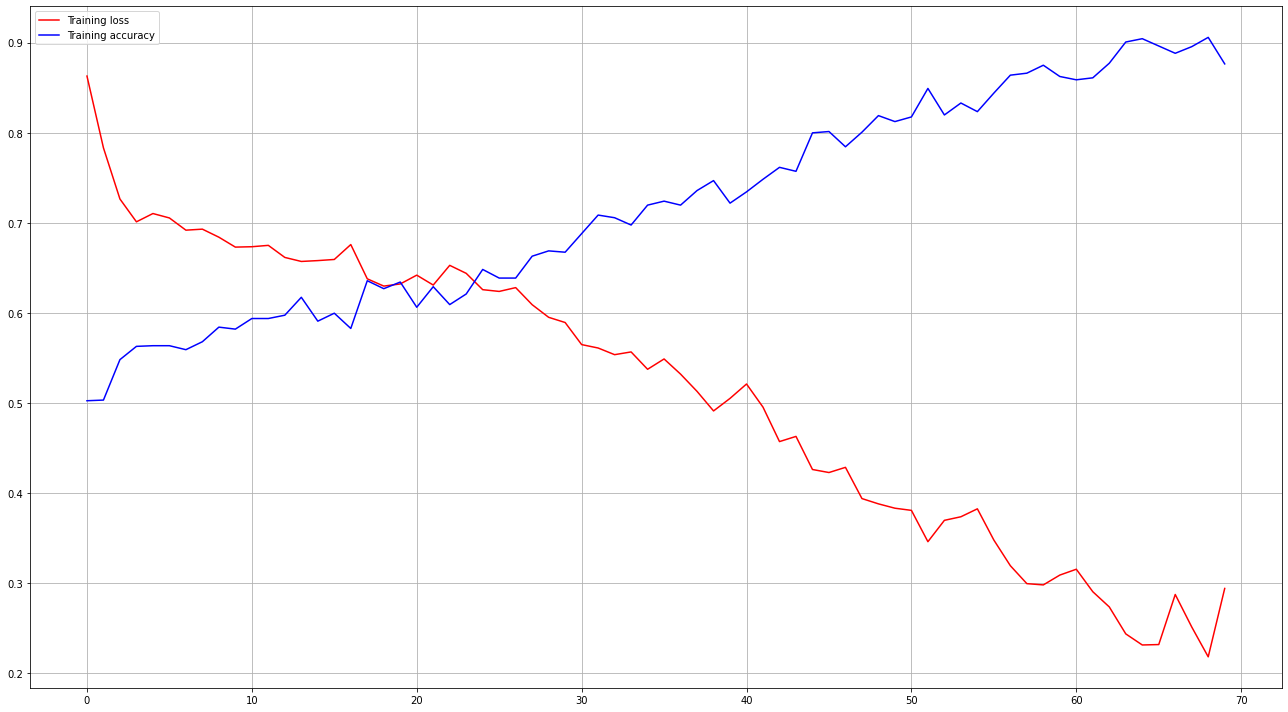

In [19]:
fig,ax = plt.subplots(1,1,figsize = (18,10))
ax.plot(model.history.history['loss'], color = 'r' , label = 'Training loss')
ax.plot(model.history.history['accuracy'], color = 'b' , label = 'Training accuracy')
plt.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [20]:
result = np.argmax(model.predict(x_test),axis=-1)
comparison = result == y_test

In [21]:
print('Ratio of false prediction over population : {}'.
      format(len(comparison[comparison == False])/x_test.shape[0]))
print('Ratio of true prediction over population : {}'.
      format(len(comparison[comparison == True])/x_test.shape[0]))

Ratio of false prediction over population : 0.14473684210526316
Ratio of true prediction over population : 0.8552631578947368
